In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [4]:
# Interaction type lookup
import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
# print(interaction_dictionary)

In [5]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [8]:
#TO FIT STRAIGHT LINES

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def fitting(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    particleType = np.array([])
    
    for i in idx:
        pdg = events.mc_pdg[i]
        particleType = np.append(particleType, pdg)
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            gradients.append(m)
            intercepts.append(c)
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
                plt.show()
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
            #print("No inliers found for a particle")
            continue
    
    return gradients, intercepts, resis, particleType

In [9]:
def energy(event_number):
    """needs to return energy in last X% over total energy"""
    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    m, c, _, _ = fitting(event_number, False)
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]   
        
        vx = events.reco_particle_vtx_x[i]
        vz = events.reco_particle_vtx_w[i]
        
        # CUTS
        
        # Discarding particles with little hits
        if x.size <= 10:
            continue
            
        if events.mc_pdg[i] == 0:
            continue
        
        if events.purity[i] < 0.75:
            continue
            
        if events.completeness[i] < 0.75:
            continue
            
        else:
            
            # Changing coordinates to along and transverse
            if m[i-idx[0]] == 0:
                continue
            else:
                znew = z - c[i-idx[0]]
                angle = -math.atan(m[i-idx[0]])

                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
                
                vznew = vz - c[i-idx[0]]
                
                vl = vx * np.cos(angle) - vznew * np.sin(angle)
                vt = vx * np.sin(angle) + vznew * np.cos(angle)
                
                if max(l) < vl:
                    l *= -1
                    
                combined = list(zip(l, t, adc))
                sort = sorted(combined, key = lambda coord: coord[0])
                
                lnew, tnew, adcnew = zip(*sort)
                
#                 plt.scatter(x,z)
#                 plt.scatter(vx, vz)
#                 plt.show()
                
#                 plt.scatter(l,t)
#                 plt.scatter(vl,vt)
#                 plt.show()
            
                # Get the last 10% of the energy data
                percent = int(0.9 * len(adcnew))
                X = adcnew[percent:]
                Xsum = np.sum(X)

                total = np.sum(adcnew)
                result = Xsum / total

                E = np.append(E, result)

                # Finding the particle type
                pdg = events.mc_pdg[i]
                particleType = np.append(particleType, pdg)   
            
            
    return E, particleType

In [10]:
energy(2934)
# max(events.event_number)

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([0.10981274, 0.0611876 , 0.08609612, 0.13233541, 0.14451368,
        0.05415674, 0.05469032, 0.07131075, 0.11018592, 0.05664275,
        0.07484812, 0.20548202, 0.15982407, 0.17922522, 0.12216068]),
 array([  13.,   22.,   22., -211.,   13.,   22.,   22.,   22.,   22.,
          22.,  -11.,  211.,  -11.,  211.,  -11.]))

In [15]:
random_numbers = np.random.randint(0, max(events.event_number), 500)

In [19]:
e = []
p = []
iteration = 0
for i in random_numbers:
    e, p = np.append(e, energy(i)[0]), np.append(p, energy(i)[1])
    print(f"Iteration number: {iteration}")
    iteration += 1  # Increment the counter


    

Iteration number: 0
Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29
Iteration number: 30
Iteration number: 31
Iteration number: 32
Iteration number: 33
Iteration number: 34
Iteration number: 35
Iteration number: 36
Iteration number: 37
Iteration number: 38
Iteration number: 39
Iteration number: 40
Iteration number: 41
Iteration number: 42
Iteration number: 43
Iteration number: 44
Iteration number: 45
Iteration number: 46
Iteration number: 47
It

In [20]:
inf = np.where(np.isinf(e))
# e = e[:-1]
# Create a boolean mask to keep or remove indices
keep_indices = np.ones(len(e), dtype=bool)
keep_indices[inf] = False

# Use boolean indexing to get the modified array
e = e[keep_indices]
p = p[keep_indices]

In [21]:
e.shape, p.shape

((2433,), (2433,))

In [22]:
df = pd.DataFrame({"energy": e, "particle": p})

In [23]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [24]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['energy'].values
showers = fshowers['energy'].values

In [25]:
# getting protons (2212) and muons out (13)

mapping2 = {
    2212: 5,
    13: 10
}

ftracks["class"] = ftracks["particle"].map(mapping2).fillna(0)

/var/folders/0j/k5n00ph57w3c1tdfq0lwsgn00000gn/T/ipykernel_50481/3133899594.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftracks["class"] = ftracks["particle"].map(mapping2).fillna(0)


In [26]:
muonsQuery = ftracks['class'] == 10.0
protonsQuery = ftracks['class'] == 5.0

fmuons = ftracks[muonsQuery]
fprotons = ftracks[protonsQuery]

muons = fmuons['energy'].values
protons = fprotons['energy'].values

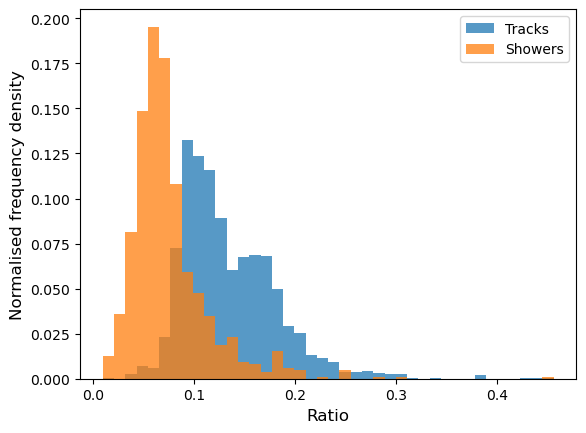

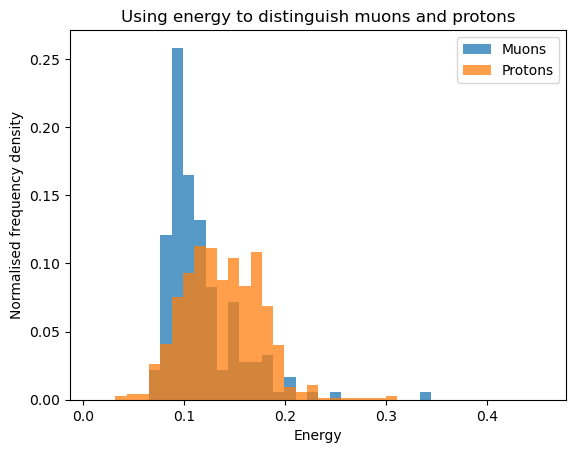

In [29]:
n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)
hist3, _ = np.histogram(muons, bins=bin_edges)
hist4, _ = np.histogram(protons, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)
hist3_normalized = hist3 / len(muons)
hist4_normalized = hist4 / len(protons)


plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')

# plt.title("Using energy to distinguish tracks and showers")
plt.ylabel("Normalised frequency density", fontsize=12)
plt.xlabel("Ratio", fontsize=12)


plt.legend()
# plt.savefig('energyHistogram.png', dpi=500)
plt.show()

plt.bar(bin_edges[:-1], hist3_normalized, width=bin_widths, align='edge', alpha=0.75, label='Muons')
plt.bar(bin_edges[:-1], hist4_normalized, width=bin_widths, align='edge', alpha=0.75, label='Protons')

plt.title("Using energy to distinguish muons and protons")
plt.ylabel("Normalised frequency density")
plt.xlabel("Energy")

plt.legend()
plt.show()

In [ ]:
# NOT IN USE!

In [ ]:
def x(event_number):
    idx = np.where(events.event_number == event_number)[0]
    
    particleType = np.array([])
    E = np.array([])
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]  
        coords = np.vstack((x, z, adc)).T
        asc = coords[coords[:, 0].argsort()]
        
        sx = asc[:, 0]
        sz = asc[:, 1]
        sadc = asc[:, 2]
        
        # Discarding particles with no hits
        if sx.size <= 30:
            continue
            
        else:
            
            # Get the last 30% of the energy data
            percent = int(0.7 * len(sadc))
            X = sadc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(sadc)
            result = Xsum / total
            
            E = np.append(E, result)
            
            # Finding the particle type
            pdg = events.mc_pdg[i]
            particleType = np.append(particleType, pdg)   
            
            
    return E, particleType